<a href="https://colab.research.google.com/github/itsmerajesh4990/AIpracticeandtraining/blob/main/Copy_of_Day6_Teacher_Reference_Activities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Teacher Reference – Day 6 Recap & Activities (Energy Plant)

This notebook is a **teacher version** of the Day 6 recap.

It includes:

- Full synthetic dataset generation (energy plant sensors)
- All activities from the recap
- **Suggested answers, explanations, and talking points** for each activity
- k-NN based anomaly/risk detection (no IsolationForest)
- A full end-to-end "Fix the Plant" simulation with interpretation notes

You can use this notebook to prepare, check answers, and guide discussions.


In [ ]:

# ===============================
# 0. Imports and global settings
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Deep learning autoencoder (optional)
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow is not installed. Autoencoder section will be illustrative only.")

%matplotlib inline
np.random.seed(42)



## 1. Synthetic Dataset – Turbine Sensor Readings

We simulate an energy plant scenario with:

- `temperature` (°C)
- `vibration` (unitless)
- `pressure` (bar)
- `failure` (0 = normal, 1 = failure/anomaly)

We also introduce **40 anomalies** with higher temperature, vibration, and pressure.


In [ ]:

# =============================================
# 1. Generate synthetic energy plant dataset
# =============================================

n_samples = 1000
time_index = pd.date_range(start="2024-01-01", periods=n_samples, freq="min")

temperature = np.random.normal(loc=160, scale=5, size=n_samples)
vibration   = np.random.normal(loc=1.0, scale=0.2, size=n_samples)
pressure    = np.random.normal(loc=32, scale=1.0, size=n_samples)

failure = np.zeros(n_samples, dtype=int)
anomaly_indices = np.random.choice(n_samples, size=4000, replace=False)

temperature[anomaly_indices] += np.random.normal(loc=20, scale=5, size=len(anomaly_indices))
vibration[anomaly_indices]   += np.random.normal(loc=3.0, scale=0.5, size=len(anomaly_indices))
pressure[anomaly_indices]    += np.random.normal(loc=2.0, scale=0.5, size=len(anomaly_indices))
failure[anomaly_indices]      = 1

sensor_df = pd.DataFrame({
    "timestamp": time_index,
    "temperature": temperature,
    "vibration": vibration,
    "pressure": pressure,
    "failure": failure
})

sensor_df.head()


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1000 non-null   datetime64[ns]
 1   temperature  1000 non-null   float64       
 2   vibration    1000 non-null   float64       
 3   pressure     1000 non-null   float64       
 4   failure      1000 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 39.2 KB



## 2. Activity 1 – Spot the Incorrect Value (Python Recap)

**Classroom activity:**  
Show a tiny sample and ask: *“Which row looks wrong?”*

**Teaching goal:**  
- Practice reading tables
- Introduce basic data quality thinking


In [ ]:

# =============================================
# 2. Activity 1 – Spot the incorrect value
# =============================================

activity1_df = pd.DataFrame({
    "timestamp": ["10:00", "10:01", "10:02", "10:03"],
    "temperature": [160, 90, 350, 162],   # 350 is clearly abnormal
    "vibration":   [0.9, 0.8, 0.7, 0.7],
    "pressure":    [32, 33, 32, 32]
})

print("Tiny sample of sensor data:")
display(activity1_df)

print("\nTeacher notes (answer):")
print("- Row with timestamp '10:02' is suspicious: temperature = 350°C.")
print("- This is likely a sensor glitch or data entry error, since others are ~160–162°C.")

# Optional: simple rule-based flag
expected_temp_min, expected_temp_max = 150, 180
activity1_df["temp_out_of_range"] = ~activity1_df["temperature"].between(expected_temp_min, expected_temp_max)

print("\nRule-based check for out-of-range temperature values (for teacher reference):")
display(activity1_df)


Tiny sample of sensor data:


,timestamp,temperature,vibration,pressure
0,10:00,160,0.9,32
1,10:01,90,0.8,33
2,10:02,350,0.7,32
3,10:03,162,0.7,32



Teacher notes (answer):
- Row with timestamp '10:02' is suspicious: temperature = 350°C.
- This is likely a sensor glitch or data entry error, since others are ~160–162°C.

Rule-based check for out-of-range temperature values (for teacher reference):


,timestamp,temperature,vibration,pressure,temp_out_of_range
0,10:00,160,0.9,32,False
1,10:01,90,0.8,33,True
2,10:02,350,0.7,32,True
3,10:03,162,0.7,32,False



## 3. Activity 2 – Simple Failure Risk Detection with k-NN (ML Recap)

We use **k-Nearest Neighbors (k-NN)** with labels:

- `failure = 0` → normal
- `failure = 1` → failure/anomaly

**Classroom flow:**

1. Show a few sample rows (mix of normal and failure).  
2. Ask: *“Which ones look risky to you?”*  
3. Then show k-NN predictions and compare with their intuition.

**Teaching goal:**  
Connect human reasoning (“similar past cases”) with k-NN logic.


In [ ]:

# =============================================
# 3. Activity 2 – k-NN failure risk detection
# =============================================

features = ["temperature", "vibration", "pressure"]
X = sensor_df[features]
y = sensor_df["failure"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_test_pred = knn.predict(X_test)
print("k-NN accuracy on test set:", accuracy_score(y_test, y_test_pred))

# Build a small sample for classroom discussion
abnormal_idxs = list(sensor_df[sensor_df["failure"] == 1].sample(2, random_state=1).index)
normal_idxs   = list(sensor_df[sensor_df["failure"] == 0].sample(3, random_state=2).index)
sample_indices = abnormal_idxs + normal_idxs

activity2_sample = sensor_df.loc[sample_indices, ["temperature", "vibration", "pressure", "failure"]].copy()
activity2_sample.reset_index(drop=True, inplace=True)

print("\nSample rows (mixture of normal and abnormal):")
display(activity2_sample)

pred_labels = knn.predict(activity2_sample[features])
pred_probs  = knn.predict_proba(activity2_sample[features])[:, 1]

activity2_sample["predicted_failure"] = pred_labels
activity2_sample["failure_probability"] = pred_probs.round(3)

print("\nModel output (teacher view):")
display(activity2_sample)

print("\nTeacher notes (answer & explanation):")
print("- Rows with true failure = 1 should generally have higher 'failure_probability'.")
print("- If k-NN predicts 1 (failure) where true label is 0, this is a false positive → good for discussion.")
print("- You can ask: 'Would you rather have a false alarm or miss a real failure? Why?'")


k-NN accuracy on test set: 1.0

Sample rows (mixture of normal and abnormal):


,temperature,vibration,pressure,failure
0,175.446222,3.441393,34.271062,1
1,170.242434,4.318452,31.389796,1
2,161.118940,0.958156,31.332220,0
3,164.497999,1.183815,32.418398,0
4,153.810923,1.191340,31.018834,0



Model output (teacher view):


,temperature,vibration,pressure,failure,predicted_failure,failure_probability
0,175.446222,3.441393,34.271062,1,1,1.000
1,170.242434,4.318452,31.389796,1,1,0.667
2,161.118940,0.958156,31.332220,0,0,0.000
3,164.497999,1.183815,32.418398,0,0,0.000
4,153.810923,1.191340,31.018834,0,0,0.000



Teacher notes (answer & explanation):
- Rows with true failure = 1 should generally have higher 'failure_probability'.
- If k-NN predicts 1 (failure) where true label is 0, this is a false positive → good for discussion.
- You can ask: 'Would you rather have a false alarm or miss a real failure? Why?'



## 4. Activity 3 – Severity Ranking with a Tree Model

We create a simple **severity label**:

- 0 = normal
- 1 = warning
- 2 = critical

Based on `failure` and `vibration`:

- If `failure = 1` and `vibration > 3` → critical  
- If `failure = 1` → warning  
- Else → normal  

**Teaching goal:**  
Show how tree-based models (RandomForest) can:

- Learn to predict severity
- Provide **feature importance** insights  


In [ ]:
# =============================================
# 4. Activity 3 – Severity ranking with RandomForest
# =============================================

def compute_severity(row):
    if row["failure"] == 1 and row["vibration"] > 3:
        return 2  # critical
    elif row["failure"] == 1:
        return 1  # warning
    else:
        return 0  # normal

sensor_df["severity"] = sensor_df.apply(compute_severity, axis=1)

features = ["temperature", "vibration", "pressure"]
X = sensor_df[features]
y = sensor_df["severity"]

# --- Diagnosis: Print severity distribution before train_test_split to illustrate the issue ---
print("\nSeverity distribution (0=normal, 1=warning, 2=critical) before split:")
print(sensor_df["severity"].value_counts())
# --- End Diagnosis ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    # Removed stratify=y because one of the severity classes has only 1 member,
    # which prevents stratification. This is often necessary for extremely rare classes.
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("RandomForest accuracy on test set:", accuracy_score(y_test, y_pred))

print("\nSeverity distribution (0=normal, 1=warning, 2=critical):")
print(sensor_df["severity"].value_counts())

importances = pd.Series(rf.feature_importances_, index=features)
print("\nFeature importance:")
display(importances.sort_values(ascending=False))

activity3_sample = sensor_df.sample(5, random_state=1)[features + ["severity"]]
activity3_sample_reset = activity3_sample.reset_index(drop=True)

pred_sev = rf.predict(activity3_sample[features])
activity3_sample_reset["predicted_severity"] = pred_sev

print("\nSample rows with true and predicted severity:")
display(activity3_sample_reset)

print("\nTeacher notes (explanation):")
print("- The most important feature is often 'vibration' due to the severity rule we defined.")
print("- Use this to explain how models can help prioritize sensors or fault types.")
print("- Any mismatches between true and predicted severity are great discussion points.")



Severity distribution (0=normal, 1=warning, 2=critical) before split:
severity
0    960
2     40
Name: count, dtype: int64
RandomForest accuracy on test set: 1.0

Severity distribution (0=normal, 1=warning, 2=critical):
severity
0    960
2     40
Name: count, dtype: int64

Feature importance:


,0
vibration,0.499033
temperature,0.374042
pressure,0.126925



Sample rows with true and predicted severity:


,temperature,vibration,pressure,severity,predicted_severity
0,155.680046,1.191061,33.244680,0,0
1,160.411420,0.957774,32.393797,0,0
2,155.071370,1.048151,31.932822,0,0
3,160.488380,0.911344,30.883476,0,0
4,162.524936,0.883664,33.976441,0,0



Teacher notes (explanation):
- The most important feature is often 'vibration' due to the severity rule we defined.
- Use this to explain how models can help prioritize sensors or fault types.
- Any mismatches between true and predicted severity are great discussion points.



## 5. Activity 4 – Autoencoder for Anomaly Score (Deep Learning Concept)

This section is optional and for **teacher depth**.

We train a small **autoencoder** on normal data only:

- It learns to reconstruct normal patterns  
- Abnormal patterns → higher reconstruction error  

**Teaching goal:**  
Explain the **idea** of deep learning–based anomaly detection, without going deep into math.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


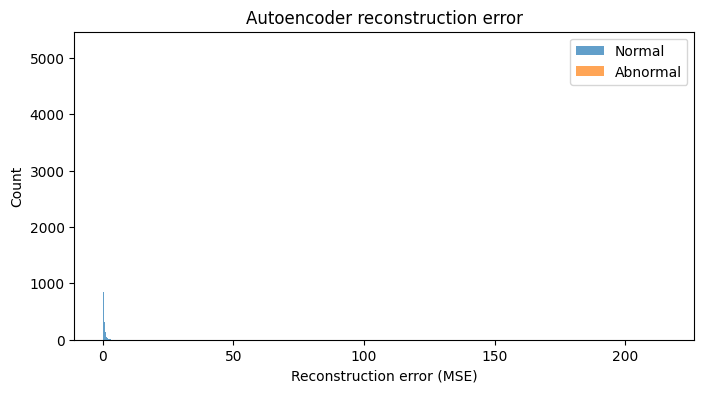

Teacher notes:
- Abnormal points should generally have higher reconstruction error.
- You can introduce the idea of choosing a threshold to flag anomalies.


In [ ]:

# =============================================
# 5. Activity 4 – Simple autoencoder (teacher depth)
# =============================================

if TF_AVAILABLE:
    from sklearn.preprocessing import StandardScaler

    normal_df = sensor_df[sensor_df["failure"] == 0][["temperature", "vibration", "pressure"]].copy()
    abnormal_df = sensor_df[sensor_df["failure"] == 1][["temperature", "vibration", "pressure"]].copy()

    scaler = StandardScaler()
    normal_scaled = scaler.fit_transform(normal_df)
    abnormal_scaled = scaler.transform(abnormal_df)

    input_dim = normal_scaled.shape[1]

    autoencoder = Sequential([
        Dense(4, activation="relu", input_shape=(input_dim,)),
        Dense(2, activation="relu"),
        Dense(4, activation="relu"),
        Dense(input_dim, activation="linear")
    ])

    autoencoder.compile(optimizer="adam", loss="mse")

    es = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
    history = autoencoder.fit(
        normal_scaled, normal_scaled,
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[es]
    )

    normal_recon = autoencoder.predict(normal_scaled)
    abnormal_recon = autoencoder.predict(abnormal_scaled)

    normal_mse = np.mean(np.square(normal_scaled - normal_recon), axis=1)
    abnormal_mse = np.mean(np.square(abnormal_scaled - abnormal_recon), axis=1)

    plt.figure(figsize=(8, 4))
    plt.hist(normal_mse, bins=40, alpha=0.7, label="Normal")
    plt.hist(abnormal_mse, bins=40, alpha=0.7, label="Abnormal")
    plt.xlabel("Reconstruction error (MSE)")
    plt.ylabel("Count")
    plt.title("Autoencoder reconstruction error")
    plt.legend()
    plt.show()

    print("Teacher notes:")
    print("- Abnormal points should generally have higher reconstruction error.")
    print("- You can introduce the idea of choosing a threshold to flag anomalies.")
else:
    print("TensorFlow is not installed. Use this section as conceptual reference only.")



## 6. Activity 5 – Model Drift Demo (MLOps)

We show how a model trained on **Period 1** data can perform worse on **Period 2** when the underlying data distribution changes.

**Teaching goal:**  
Explain why monitoring and retraining are critical in production.


In [ ]:

# =============================================
# 6. Activity 5 – Drift demonstration
# =============================================

mid_point = n_samples // 2
period1 = sensor_df.iloc[:mid_point].copy()
period2 = sensor_df.iloc[mid_point:].copy()

features = ["temperature", "vibration", "pressure"]
X1 = period1[features]
y1 = period1["failure"]

X2 = period2[features]
y2 = period2["failure"]

rf_drift = RandomForestClassifier(n_estimators=100, random_state=42)
rf_drift.fit(X1, y1)

y1_pred = rf_drift.predict(X1)
acc1 = accuracy_score(y1, y1_pred)

X2_drifted = X2.copy()
X2_drifted["temperature"] += 20
X2_drifted["vibration"] += 1.5 # Introduce drift to vibration
X2_drifted["pressure"] += 1.0   # Introduce drift to pressure

y2_pred = rf_drift.predict(X2_drifted)
acc2 = accuracy_score(y2, y2_pred)

print(f"Accuracy on Period 1 (training-like data): {acc1:.3f}")
print(f"Accuracy on Period 2 (drifted data):      {acc2:.3f}")

print("\nTeacher notes:")
print("- The drop in accuracy on Period 2 illustrates data drift.")
print("- Use this to motivate: monitoring dashboards, alerts, and retraining policies.")


Accuracy on Period 1 (training-like data): 1.000
Accuracy on Period 2 (drifted data):      0.127

Teacher notes:
- The drop in accuracy on Period 2 illustrates data drift.
- Use this to motivate: monitoring dashboards, alerts, and retraining policies.



## 7. Full Simulation – "Fix the Plant" (End-to-End)

We use:

- k-NN model (failure risk)
- RandomForest model (severity)
- Simple rule-based action suggestion

**Teaching goal:**  
Show how multiple models + simple rules can support decision-making in an energy plant.


In [ ]:

# =============================================
# 7. Full Simulation – Fix the Plant
# =============================================

# Take the last 10 readings as the "current situation"
fix_plant_sample = sensor_df.tail(10).copy()
fix_plant_sample = fix_plant_sample.reset_index(drop=True)

print("Recent 10 readings (teacher view):")
display(fix_plant_sample[["timestamp", "temperature", "vibration", "pressure", "failure", "severity"]])

# Use k-NN to estimate failure risk
fix_plant_sample["predicted_failure"] = knn.predict(fix_plant_sample[features])
fix_plant_sample["failure_probability"] = knn.predict_proba(fix_plant_sample[features])[:, 1]

# Use RandomForest to estimate severity
fix_plant_sample["predicted_severity"] = rf.predict(fix_plant_sample[features])

# Suggested actions
def suggest_action(row):
    if row["predicted_severity"] == 2:
        return "Immediate inspection & potential shutdown"
    elif row["predicted_severity"] == 1:
        return "Schedule maintenance soon & monitor closely"
    else:
        return "Normal monitoring"

fix_plant_sample["suggested_action"] = fix_plant_sample.apply(suggest_action, axis=1)

print("\nModel-driven view (failure risk, severity, actions):")
display(fix_plant_sample[["timestamp", "temperature", "vibration", "pressure",
                          "predicted_failure", "failure_probability",
                          "predicted_severity", "suggested_action"]])

print("\nTeacher notes:")
print("- Use this table to ask: 'Which timestamps would you act on first, and why?'")
print("- Compare model suggestions with the true 'failure' label.")
print("- Great point to bridge into GenAI/LLM: turning these outputs into natural language reports.")


Recent 10 readings (teacher view):


,timestamp,temperature,vibration,pressure,failure,severity
0,2024-01-07 22:30:00,163.770271,1.024048,30.300986,0,0
1,2024-01-07 22:31:00,163.615115,0.991778,32.042414,0,0
2,2024-01-07 22:32:00,153.943194,0.992326,30.165558,0,0
3,2024-01-07 22:33:00,164.999722,0.897976,30.202477,0,0
4,2024-01-07 22:34:00,155.009497,1.004965,31.946900,0,0
5,2024-01-07 22:35:00,159.867925,0.829846,31.474107,0,0
6,2024-01-07 22:36:00,151.909404,0.762438,34.078946,0,0
7,2024-01-07 22:37:00,159.102658,0.750691,31.746619,0,0
8,2024-01-07 22:38:00,154.982068,0.790179,33.135147,0,0
9,2024-01-07 22:39:00,157.755714,1.084457,32.051638,0,0



Model-driven view (failure risk, severity, actions):


,timestamp,temperature,vibration,pressure,predicted_failure,failure_probability,predicted_severity,suggested_action
0,2024-01-07 22:30:00,163.770271,1.024048,30.300986,0,0.0,0,Normal monitoring
1,2024-01-07 22:31:00,163.615115,0.991778,32.042414,0,0.0,0,Normal monitoring
2,2024-01-07 22:32:00,153.943194,0.992326,30.165558,0,0.0,0,Normal monitoring
3,2024-01-07 22:33:00,164.999722,0.897976,30.202477,0,0.0,0,Normal monitoring
4,2024-01-07 22:34:00,155.009497,1.004965,31.946900,0,0.0,0,Normal monitoring
5,2024-01-07 22:35:00,159.867925,0.829846,31.474107,0,0.0,0,Normal monitoring
6,2024-01-07 22:36:00,151.909404,0.762438,34.078946,0,0.0,0,Normal monitoring
7,2024-01-07 22:37:00,159.102658,0.750691,31.746619,0,0.0,0,Normal monitoring
8,2024-01-07 22:38:00,154.982068,0.790179,33.135147,0,0.0,0,Normal monitoring
9,2024-01-07 22:39:00,157.755714,1.084457,32.051638,0,0.0,0,Normal monitoring



Teacher notes:
- Use this table to ask: 'Which timestamps would you act on first, and why?'
- Compare model suggestions with the true 'failure' label.
- Great point to bridge into GenAI/LLM: turning these outputs into natural language reports.
